### Домашнее задание 2

пока можете прокручивать.

In [1]:
!pip install -q ipdb

     |████████████████████████████████| 791 kB 11.5 MB/s 
     |████████████████████████████████| 374 kB 50.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.24 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.30.1 which is incompatible.


In [2]:
!pip install -q torchmetrics

     |████████████████████████████████| 332 kB 11.3 MB/s 


In [3]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import ipdb

In [4]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics import F1
from torchmetrics.functional import f1, recall
import ipdb

In [5]:
import torch

Начинаем: скачиваем файлы, делаем датафреймы, делим на тест и трейн, препроцессим, создаем на будущее словари..

In [6]:
pos_tweets = pd.read_csv('positive.csv', encoding='utf-8', sep=';', header=None,  names=[0,1,2,'text','tone',5,6,7,8,9,10,11])
neg_tweets = pd.read_csv('negative.csv', encoding='utf-8', sep=';', header=None, names=[0,1,2,'text','tone',5,6,7,8,9,10,11] )
neg_tweets['tone'] = 0
all_tweets_data = pos_tweets.append(neg_tweets)
print(len(all_tweets_data))

226834


In [7]:
tweets_data = shuffle(all_tweets_data[['text','tone']])[:100000]

In [8]:
train_sentences, val_sentences = train_test_split(tweets_data, test_size=0.1)

In [9]:
train_sentences[:10]


,text,tone
82217,@De_nativo Будем считать что красные яблочки и...,1
74458,"В том, что это может быть провокация, я не в о...",1
34731,RT @silver_xenia: температура( совсем плохо,0
27934,@sassy_lolz да ведь не за что)\nэто просто мне...,1
19779,@vesti_kpss из некогда монстров разве что Уотр...,0
49064,RT @VmesteCitations: Ну праааавда(( http://t.c...,0
36093,"""только похоже я одна его буду пить, потому чт...",1
72278,Ахаха\nСаша блин.\nКак всегда.\nПросто иди нах...,1
4151,RT @pedazyzuvab: Да... Давно сердце не болело....,0
77970,"@sport_by если команда так решила,значит им ви...",1


In [10]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [11]:
vocab = Counter()

for text in tweets_data['text']:
    vocab.update(preprocess(text))
print('всего уникальных токенов:', len(vocab))

всего уникальных токенов: 202880


In [12]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 2:
        filtered_vocab.add(word)
print('уникальных токенов, втретившихся больше 2 раз:', len(filtered_vocab))

уникальных токенов, втретившихся больше 2 раз: 32444


In [13]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

Начинаем притрагиваться к нейросетям.

In [14]:
id2word = {i:word for word, i in word2id.items()}

In [65]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [66]:
class TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['tone'].values
        self.device = DEVICE

    def __len__(self): 
        return self.length

    def __getitem__(self, index): 
        tokens = self.preprocess(self.dataset[index]) 
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return ids, y
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

    def collate_fn(self, batch):
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_ids, y

In [67]:
train_dataset = TweetsDataset(train_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [68]:
val_dataset = TweetsDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [69]:
class CNN0(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.svertka = nn.Conv1d(in_channels=180, out_channels=180, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=180, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        embedded = self.embedding(word) # эмбеддинги
        embedded = embedded.transpose(1,2)
        feature_map_bigrams = self.bigrams(embedded) # свертка первая
        feature_map_trigrams = self.trigrams(embedded) # свертка вторая
        concat1 = torch.cat((feature_map_bigrams, feature_map_trigrams), 1) # конкатенируем
        sv = self.pooling(self.svertka(concat1))
        pooling0 = sv.max(2)[0] # макспулинг
        
        logits = self.hidden(pooling0) #линейный
        logits = self.out(logits)  # сигмоида    
        return logits

In [70]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 

    model.train()  

    for i, (texts, ys) in enumerate(iterator): 
        optimizer.zero_grad() 
        preds = model(texts)  
        loss = criterion(preds, ys)   
        loss.backward()   
        optimizer.step() 
        epoch_loss += loss.item() 
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) 

In [71]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  
            loss = criterion(preds, ys)  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/(i+1)}, Val f1: {epoch_metric/(i+1)}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) 

In [72]:
model0 = CNN0(len(word2id), 100)
optimizer = optim.Adam(model0.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

model0 = model0.to(DEVICE)
criterion = criterion.to(DEVICE)

In [73]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model0, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model0, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model0, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7146475538611412
Train loss: 0.6799866448749196
Train loss: 0.663764420747757
Train loss: 0.6528879154973956
Train loss: 0.645861240369933

Evaluating on train...
Val loss: 0.5946033000946045, Val f1: 0.6676478385925293
Val loss: 0.595921961700215, Val f1: 0.6654272079467773
Val loss: 0.5962702690386305, Val f1: 0.6665107607841492
Val loss: 0.5959943795905394, Val f1: 0.6674714684486389
Val loss: 0.596836397227119, Val f1: 0.6658844351768494

Evaluating on test...
Val loss: 0.6090579032897949, Val f1: 0.645500898361206
Val loss: 0.6073446124792099, Val f1: 0.6486740112304688
Val loss: 0.6082810461521149, Val f1: 0.6483373641967773
Val loss: 0.6083066537976265, Val f1: 0.6477082967758179
Val loss: 0.6088057637214661, Val f1: 0.6511055827140808

starting Epoch 1
Training...
Train loss: 0.6325365677475929
Train loss: 0.6108519471052921
Train loss: 0.6020670986175537
Train loss: 0.5968398398427821
Train loss: 0.5932337471417019

Evaluating on tra

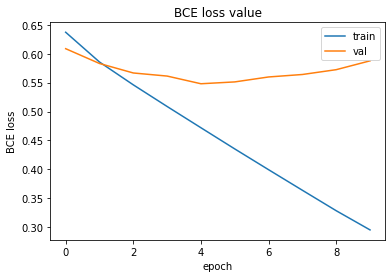

In [74]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Выглядит отстойно: во-перых очевидное переобучение, во-вторых в лучшем случае лосс на тесте около 0,55, это как-то не оч.

Улучшим дропаутами, пулингами и релу между сверточными слоями:

In [75]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.svertka = nn.Conv1d(in_channels=180, out_channels=180, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=180, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)
        feature_map_bigrams = self.dropout(self.pooling(self.relu(self.bigrams(embedded))))
        feature_map_trigrams = self.dropout(self.pooling(self.relu(self.trigrams(embedded))))
        concat1 = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        sv = self.pooling(self.relu(self.svertka(concat1)))
        pooling0 = sv.max(2)[0]
        
        logits = self.hidden(pooling0) 
        logits = self.out(logits)      
        return logits

In [76]:
model = CNN(len(word2id), 100)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [77]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7397546470165253
Train loss: 0.7109098705378446
Train loss: 0.6986915159225464
Train loss: 0.6897014566321871
Train loss: 0.6820289662906102

Evaluating on train...
Val loss: 0.6373868935248431, Val f1: 0.6449377536773682
Val loss: 0.6353673005805296, Val f1: 0.6482030153274536
Val loss: 0.634827061026704, Val f1: 0.6487230062484741
Val loss: 0.6346185356378555, Val f1: 0.6483426094055176
Val loss: 0.6340846293112811, Val f1: 0.6495673656463623

Evaluating on test...
Val loss: 0.6380287110805511, Val f1: 0.6416146755218506
Val loss: 0.6369955092668533, Val f1: 0.6448604464530945
Val loss: 0.6379000047842661, Val f1: 0.6395613551139832
Val loss: 0.6375073716044426, Val f1: 0.640622615814209
Val loss: 0.6380674004554748, Val f1: 0.6427370309829712

starting Epoch 1
Training...
Train loss: 0.6782318986952305
Train loss: 0.6550261125420079
Train loss: 0.6467426145076751
Train loss: 0.6400342183326607
Train loss: 0.6364160925149918

Evaluating on 

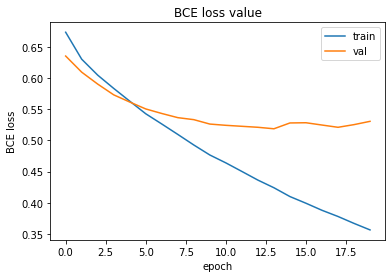

In [37]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

вроде получше?))) мы спаслись от переобучения, но лучший лосс на тесте не сильно изменился.

Теперь попробуем с предобученными эмбеддингами:


In [78]:
import gensim
texts = all_tweets_data.text.apply(preprocess).tolist()
w2v = gensim.models.Word2Vec(texts, size=100, window=5, min_count=1)

In [79]:
weights = np.zeros((len(word2id), 100))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = w2v.wv[word]    
    except KeyError:
      count += 1
      # oov словам сопоставляем случайный вектор
      weights[i] = np.random.normal(0,0.1,100)

In [80]:
class CNN_emb(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.svertka = nn.Conv1d(in_channels=180, out_channels=180, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=180, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        #batch_size x seq_len
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)
        feature_map_bigrams = self.dropout(self.pooling(self.relu(self.bigrams(embedded))))
        feature_map_trigrams = self.dropout(self.pooling(self.relu(self.trigrams(embedded))))
        concat1 = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        sv = self.pooling(self.relu(self.svertka(concat1)))
        pooling0 = sv.max(2)[0]
        
        logits = self.hidden(pooling0) 
        logits = self.out(logits)      
        return logits

In [81]:
model2 = CNN_emb(len(word2id), 100)
optimizer = optim.Adam(model2.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

model2 = model2.to(DEVICE)
criterion = criterion.to(DEVICE)

In [82]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model2, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model2, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model2, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7348674312233925
Train loss: 0.7067410151163737
Train loss: 0.6935847520828247
Train loss: 0.6841898658382359
Train loss: 0.6764296967358816

Evaluating on train...
Val loss: 0.6266885329695309, Val f1: 0.6096464991569519
Val loss: 0.6250040601281559, Val f1: 0.6147249937057495
Val loss: 0.6248770297742358, Val f1: 0.6149740815162659
Val loss: 0.6257970368160921, Val f1: 0.6135932803153992
Val loss: 0.6259050123831805, Val f1: 0.6147226095199585

Evaluating on test...
Val loss: 0.6286381185054779, Val f1: 0.6194698810577393
Val loss: 0.6272288858890533, Val f1: 0.616374135017395
Val loss: 0.6296482384204865, Val f1: 0.6119556427001953
Val loss: 0.6292624026536942, Val f1: 0.6098564863204956
Val loss: 0.6299563586711884, Val f1: 0.6109765768051147

starting Epoch 1
Training...
Train loss: 0.6709494367241859
Train loss: 0.6481855999339711
Train loss: 0.6397007489204407
Train loss: 0.6344443577439037
Train loss: 0.6303083619901112

Evaluating on

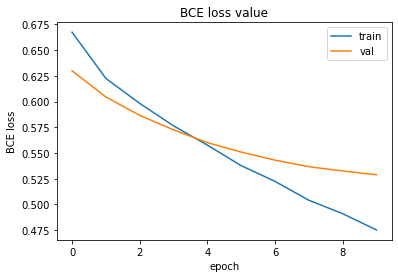

In [83]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

получается так же как с обучающимися эмбеддингами

давайте попробуем изучить ошибки

In [84]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts) 
            for pred, gold, text in zip(preds, ys, texts):
              text = ' '.join([id2word[int(symbol)] for symbol in text if symbol !=0])
              if round(pred.item()) > gold:
                fp.append(text)
              elif round(pred.item()) < gold:
                fn.append(text)
              elif round(pred.item()) == gold == 1:
                tp.append(text)
              elif round(pred.item()) == gold == 0:
                tn.append(text)
    return fp, fn, tp, tn

In [85]:
fp, fn, tp, tn = predict(model, val_iterator)

In [86]:
print('true positive: ', tp[:25])

true positive:  ['получила удовольствие от просмотра советую', 'rt ты просто на дне ещё не разу не', 'я намекаю на то что по кругу и и вообще я ты не знал', 'настолько разочаровалась в парня что задумываюсь перейти на девушек', 'спасибо накатило 100 лет эту песню не слушала', 'опиши мене за 5 слів — маленька', 'rt оказывается сегодня международный день переводчика ну что коллеги и единомышленники с праздником что ли', 'ленты только райот по к2 х мои ж', 'с вовой и проводили на задавали по 11 вопросов о коррупции поржали от души d', 'глупо задавать вопрос ответ на который итак знаешь', 'потому что я работаю на фбр и хорошо и не только', 'монголын минь хүний нэг ын бэлэг диск', 'могу набери в гугле или в хрома', 'все равно так себе смотреть надо в оригинале но это очень мило что они его показывают', 'плохие привычки нельзя уничтожить но их место можно заменить другими d', 'patrikoksi я в этом уверен меня они всегда спасают правда иногда через спасают', 'rt у мамы попрошу что бы купила мн

In [87]:
print('ошибочно считаем позитивными: ', fp[:25])

ошибочно считаем позитивными:  ['именно ты права но тут считают что', 'маме с утра на счет этого концерта она не отпускает из-за учебы окай', 'алкоголь тут с 11 ну збс надо на ром что ли развести мать', 'уйду я от вас в злые вы все меня уже который раз все', 'тетя сказала щас снег бабушке поедем', 'уже 2-ой день подряд все красивые парни выходят на', 'да я уже с самого утра скучаю там по всем', 'это не хорошо сходи к зубному он её чем-нибудь', 'я же еще недавно спрашивала у бабушки уверенна ли она в том что вика так не и она ответила что уверенна', 'кармане 20 еще надо в автошколу потом как то домой добираться', 'день без макияжа и всее знакомые парни случайно на тебя в минске уу', 'santairis у нас вон все воду в европе им жить захотелось как будто они в африке живут мрази', 'села греться а то вообще какое-то состояние неправильное', 'потому что вот не все хлопья одинаково полезны', 'купила угги в а то ноги бы в сапогах на платформе', 'ты любишь морковку — не лезь в мою жизнь', 'и в во

In [88]:
print('ошибочно считаем негативными: ', fn[:25])

ошибочно считаем негативными:  ['кто еще сам доехал до работы кроме меня и', 'сдала две контрольные по анатомии осталась одна и свалю нафиг', 'rt я знаю мои соседи хотят послушать led zeppelin', 'хотя у меня есть верный друг который всегда со мной а значит нас двое а значит уже нихуя не страшно', 'запихнуть в вот было бы хорошо', 'а я отвечу что какой кошмар а я не пишу с видимо и не сдам х', 'все мои друзья общаются со мной в соц сетях по разному и к каждому у меня свой я не знаю какая я', 'да,я тоже хочу новогоднюю ночь с', 'rt 27_wrm mimifka ну понятно и за стулья где работу унесли и сказали здесь сиди', 'блять я к своему коту привык это же не значит что я с ним то должна быть какая-то', 'женечка спит после операции', 'сообщает о том что в москве редкие снежинки будьте осторожны за рулем снег', 'давай а то блин я же умру от скуки без тебя', 'каждую ты наверное не высыпаться я имею в', 'пиздец ночка утречко конечно зато поржали от души', 'rt завтра не будет можно будет не учить', 'се

Честно говоря, у меня вообще большие вопросы к тому, кто размечал эти твиты... Но наверное можно объяснить часть ошибок очень просто: в твите есть какое-то слово, которое часто употребляется в позитивном ключе, например, офигенно. И если твит типа "мама выгнала из дома, ну офигенно", моделька прочитает слово офигенно и решит, что он радостный :)

## посимвольно

Словарики, подготовка...

In [15]:
vocab_s = Counter()
for symbol in tweets_data['text']:
    vocab_s.update(list(symbol))
print('всего уникальных символов:', len(vocab_s))

всего уникальных символов: 361


In [16]:
filtered_vocab_s = set()

for symbol in vocab_s:
    if vocab_s[symbol] > 5:
        filtered_vocab_s.add(symbol)
print('уникальных символов, втретившихся больше 5 раз:', len(filtered_vocab_s))

уникальных символов, втретившихся больше 5 раз: 211


In [17]:
symbol2id = {'PAD':0}

for symbol in filtered_vocab:
    symbol2id[symbol] = len(symbol2id)

In [18]:
id2symbol = {i:symbol for symbol, i in symbol2id.items()}

Делаем датасет, надо добавить новый словарик, и не забыть сделать поля для символов всякие.

In [19]:
class Dataset2(Dataset):

    def __init__(self, dataset, word2id, symbol2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = dataset['tone'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = self.preprocess(self.dataset[index])
        symbols = list(self.dataset[index])
        ids = torch.LongTensor([self.word2id[tok] for tok in tokens if tok in self.word2id])
        ids_s = torch.LongTensor([self.symbol2id[symbol] for symbol in symbols if symbol in self.symbol2id])
        y = [self.target[index]]
        return ids, ids_s, y

    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens
        
    def collate_fn(self, batch):
      ids, ids_s, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      padded_ids_s = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_ids, padded_ids_s, y

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [21]:
train_dataset = Dataset2(train_sentences, word2id, symbol2id, device)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [22]:
val_dataset = Dataset2(train_sentences, word2id, symbol2id, device)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

Моделька вроде такая как в условии задачи: эмбеддинги для слов, mean, линейный слой, эмбеддинги для символов, свертки с разным окном, макспулинг. Потом конкатенация этого всего, линейный слой и сигмоида.

In [32]:
class My_model(nn.Module):
    
    def __init__(self, vocab_size, s_size, embedding_dim, s_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(in_features=embedding_dim, out_features=180)
        self.embedding_s = nn.Embedding(s_size, s_dim)
        self.bigrams = nn.Conv1d(in_channels=s_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=s_dim, out_channels=80, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=360, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, text, symb):
        embedded = self.embedding(text).mean(axis=1)
        embedded = self.linear1(embedded)
        embedded_s = self.embedding_s(symb)
        embedded_s = embedded_s.transpose(1,2)
        feature_map_bigrams = self.bigrams(embedded_s)
        feature_map_trigrams = self.trigrams(embedded_s)
        pooling1 = feature_map_bigrams.max(2)[0] 
        pooling2 = feature_map_trigrams.max(2)[0]
        concat = torch.cat((pooling1, pooling2, embedded), 1)
        logits = self.hidden(concat) 
        logits = self.out(logits)      
        return logits

In [24]:
model = My_model(len(word2id), len(symbol2id), 100, 8)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

model = model.to(device)
criterion = criterion.to(device)

In [25]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 

    model.train()

    for i, (*data, ys) in enumerate(iterator):
        optimizer.zero_grad()  
        preds = model(*data) 
        loss = criterion(preds, ys) 
        loss.backward()  
        optimizer.step() 
        epoch_loss += loss.item() 
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/(i+1)}')      
    return  epoch_loss / len(iterator) 

In [26]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (*data, ys) in enumerate(iterator):   
            preds = model(*data) 
            loss = criterion(preds, ys)   
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/(i+1)}, Val f1: {epoch_metric/(i+1)}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [27]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)


Train loss: 0.695165052133448
Train loss: 0.6918146259644452
Train loss: 0.6893303464440739
Train loss: 0.6871171821566189
Train loss: 0.6846825648756588

Evaluating on train...
Val loss: 0.6684726476669312, Val f1: 0.6437727808952332
Val loss: 0.670041701372932, Val f1: 0.6414141654968262
Val loss: 0.6698340002228232, Val f1: 0.6416688561439514
Val loss: 0.6700607029830709, Val f1: 0.6414313912391663
Val loss: 0.6701523836921243, Val f1: 0.6403388381004333

Evaluating on test...
Val loss: 0.6696486753575942, Val f1: 0.6414955854415894
Val loss: 0.6692235890556785, Val f1: 0.643690824508667
Val loss: 0.6697215998873991, Val f1: 0.6416450142860413
Val loss: 0.6698906991411658, Val f1: 0.6414837837219238
Val loss: 0.6699846141478595, Val f1: 0.640643835067749

starting Epoch 1
Training...
Train loss: 0.6678067130201003
Train loss: 0.6649731800836676
Train loss: 0.6618382755447837
Train loss: 0.6593386679887772
Train loss: 0.6561734998927397

Evaluating on train...
Val loss: 0.63716604429

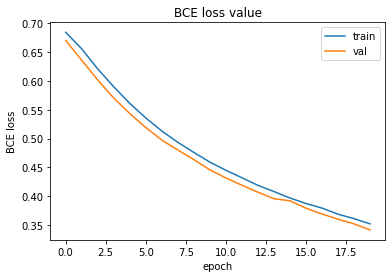

In [28]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

хорошо работает, но мы явно обучались недостаточно. Поэтому выбираем очевидное улучшение из области гиперпараметров: увеличим learning rate. Попробуем!

In [33]:
model = My_model(len(word2id), len(symbol2id), 100, 8)
optimizer = optim.Adam(model.parameters(), lr=0.05)
criterion = nn.BCELoss()  

model = model.to(device)
criterion = criterion.to(device)

In [34]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 14.799325027886558
Train loss: 7.787989225457697
Train loss: 5.39302856314416
Train loss: 4.179273650488433
Train loss: 3.448862687629812

Evaluating on train...
Val loss: 0.4196363126530367, Val f1: 0.8217780590057373
Val loss: 0.42051176902125864, Val f1: 0.8214549422264099
Val loss: 0.41790415609584136, Val f1: 0.8233989477157593
Val loss: 0.4189476787167437, Val f1: 0.8219126462936401
Val loss: 0.41852806876687443, Val f1: 0.8222275972366333

Evaluating on test...
Val loss: 0.41733359238680673, Val f1: 0.8251870274543762
Val loss: 0.4165753739721635, Val f1: 0.8242642879486084
Val loss: 0.4173564455088447, Val f1: 0.8230541944503784
Val loss: 0.4168538056752261, Val f1: 0.8232453465461731
Val loss: 0.41829064523472503, Val f1: 0.8222987651824951

starting Epoch 1
Training...
Train loss: 0.4076569956891677
Train loss: 0.4082500943366219
Train loss: 0.4162032948989494
Train loss: 0.4244437695426099
Train loss: 0.42742509947103613

Evaluating 

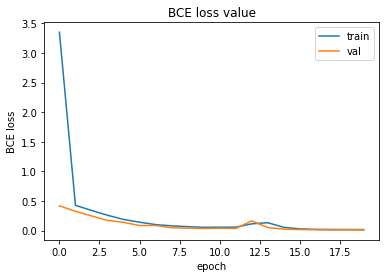

In [35]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

это работает потрясающе.

Попробуем поанализировать



In [61]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, symbs, ys) in enumerate(iterator):   
            preds = model(texts, symbs) 
            for pred, gold, text, symb in zip(preds, ys, texts, symbs):
              text = ' '.join([id2word[int(symbol)] for symbol in text if symbol !=0])
              if round(pred.item()) > gold:
                fp.append(text)
              elif round(pred.item()) < gold:
                fn.append(text)
              elif round(pred.item()) == gold == 1:
                tp.append(text)
              elif round(pred.item()) == gold == 0:
                tn.append(text)
    return fp, fn, tp, tn

In [62]:
fp, fn, tp, tn = predict(model, val_iterator)

In [64]:
print('true positive: ', tp[:25])

true positive:  ['de_nativo будем считать что красные яблочки и что-то там ещё уважения цветам деда мороза', 'в том что это может быть я не в одиночестве', 'sassy_lolz да ведь не за что это просто мнение мое', 'только похоже я одна его буду пить потому что лера за зож а у оли парень и печень', 'ахаха саша блин как всегда просто иди нахуй это вечное', 'sport_by если команда так им выходные без даши', 'ну ты-то меня понимаешь знаю я как ты любишь жрать', 'даже и не знаю,что лучше жить с тобой или жить дома можно ведь дома с тобой d', 'планы на неделю в форму курсач делать новый кубок с личной жизнью сдохнуть', 'usastupidd воть про майдан', 'и для эффекта сразу серию после 6-й', 'и кстати в борьбе за русь', 'ахах сейчас меня моя физручка тогда будет должна вам', 'русская версия про выглядит всё-таки', 'с утра завтра сделаю математику схожу в ванную и в школоло на третий урок', 'meetprettyshit классно с я буду очень ждать это письмецо', 'от скуки превращаюсь в твит в секунду но твой рекорд

In [63]:
print('ошибочно не относим к позитивным:', fn[:25])

ошибочно не относим к позитивным: ['ты только что пришла в школу сколько можно', 'ахахаха я долго не мог потом понял дело в', 'а вообще я кажется купила все для нового года и это такое облегчение', 'а что с', 'люблю спать', 'ааа это реально ужасный момент был я то думала ты 2 часть смотришь', 'у нас тут тоже новогоднее настроение', 'ты его не могу ж его', 'и не', 'ахаха я свой ответ и поняла что тоже ничего не', 'я ну', 'а вот и нет один раз и все', 'я не а', 'но всегда и', 'а я вообще на тебя', 'зато они там совсем дождаться фото', 'в школе надо по поем', 'вряд ли меня когда-нибудь лучше', 'ну это а у меня', 'мне уже тоже', 'это было так не похоже на него teamfollowback', 'rt не', 'rt хочу нг в школе много как это все', 'я тоже', 'завтра еду на по немного а пока всем во']


In [53]:
print('ошибочно считаем позитивными:', fp[:25])

ошибочно считаем позитивными: ['rt ну', 'пока ты ее не получишь я не', '', 'спасибо', 'короче второй урок я уже пойду на третий не хочу идти вообще', 'а мне есть куда но папа сказал что даже не подумает мне его купить', 'rt же', '', 'доброе утро где ты', 'не хочу тебя', '', 'rt ты', 'один раз и я почти с нее', 'с ним', 'утро начинается не с кофе', 'rt со', 'ахаха ты бы видела кто мне это', '', 'rt', 'rt', 'а может вас как', '', 'и', 'желание на новый год', '']


Многие из этих твитов короткие, или непонятные, или как будто не целые. В целом, я бы сама испытывала трудности их оценить))